# Import libraries

In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import zipfile
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, save_model, model_from_json
from keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

# Global Variabel

In [2]:
num_classes = 8
width, height = 48, 48
epochs = 100

# Load Dataset

<h3>Exploratory Data Analysis (EDA)</h3>

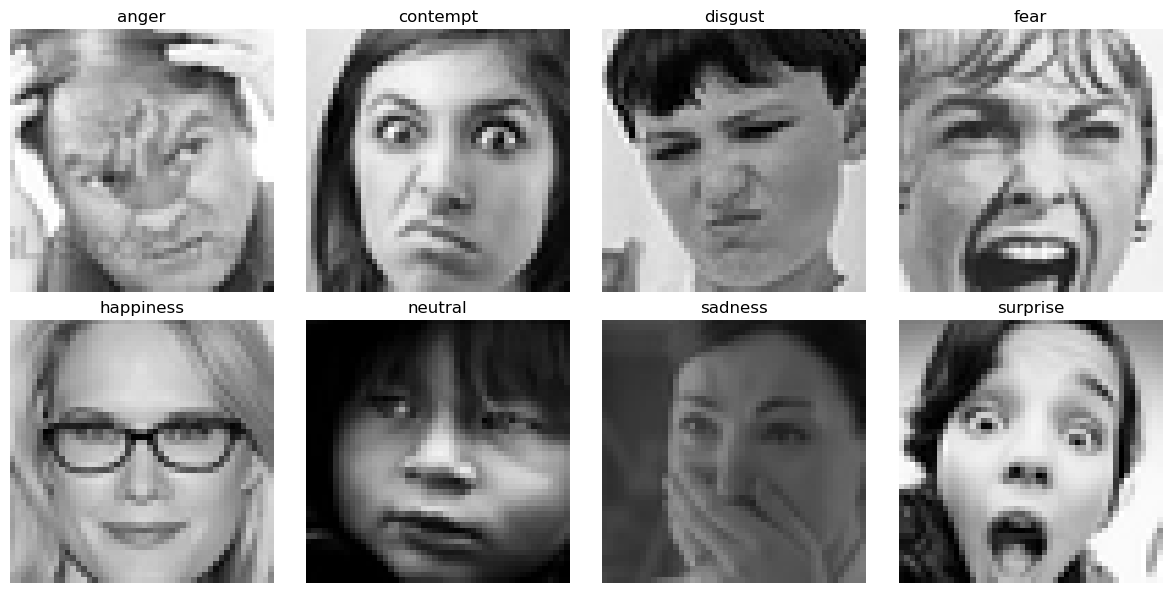

In [3]:
# Define dataset path
dataset_path = "fer2013/train"

# Get class names (subfolder names)
class_names = os.listdir(dataset_path)

# Set up figure for displaying images
plt.figure(figsize=(12, 6))

# Load and display one image per class
for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    # Get first image in the class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png') or f.endswith('.jpg')]
    if image_files:
        image_path = os.path.join(class_path, random.choice(image_files))
        image = load_img(image_path)  # Load image

        # Display image
        plt.subplot(2, 4, i + 1)  # Adjust grid based on class count
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

Total Images in Dataset: 28386
Total Classes: 8

Count of images per class:
       Class  Image Count
0      anger         2466
1   contempt          165
2    disgust          191
3       fear          652
4  happiness         7528
5    neutral        10308
6    sadness         3514
7   surprise         3562


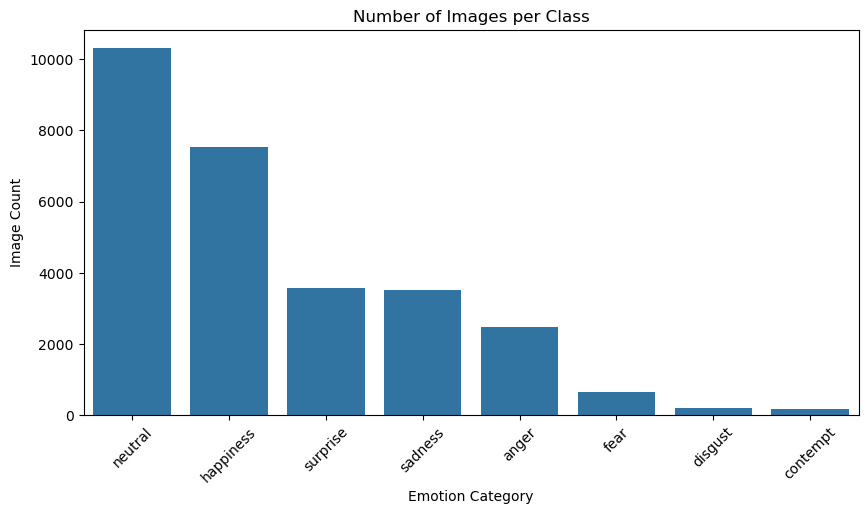

In [4]:
# Define dataset path
dataset_path = "fer2013/train"

# Get class names (subfolder names)
class_names = os.listdir(dataset_path)

# Count the number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in class_names}

# Convert to Pandas DataFrame for easy display
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

# Display counts
print("Total Images in Dataset:", df["Image Count"].sum())
print("Total Classes:", len(df))

print("\nCount of images per class:")
print(df)

# Optional: Sort and visualize
df = df.sort_values(by="Image Count", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Image Count", data=df)
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.xlabel("Emotion Category")
plt.ylabel("Image Count")
plt.show()

<h3>Make Train and Test Generator</h3>

In [5]:
# Make an image augmentation generator for train data
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     horizontal_flip=True,
                                     zoom_range=0.2)
train_dataset = train_generator.flow_from_directory('fer2013/train',
                                                    target_size=(48,48),
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    shuffle=True)

# Make an image augmentation generator for test data
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = train_generator.flow_from_directory('fer2013/test',
                                                    target_size=(48,48),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [6]:
# Get a batch of images and labels from train_dataset
images, labels = next(train_dataset)

# Check a single image shape
print("Single image shape:", images[0].shape)

Single image shape: (48, 48, 3)


# Build the Model (Using the Sequential class API)

In [7]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(width, height, 3)))
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# 6th Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 7th Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# 8th Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten Layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 2nd Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 3rd Fully Connected Layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1

<h3>Setting Up the Callbacks</h3>

In [8]:
checkpoint = ModelCheckpoint('emotion.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks = [earlystop, checkpoint, reduce_lr]

<h3>Model Fit</h3>

In [9]:
history = model.fit(train_dataset, 
                    callbacks=callbacks, 
                    epochs=epochs, 
                    validation_data=test_dataset)

Epoch 1/100
1775/1775 [==============================] - 93s 50ms/step - loss: 1.5895 - accuracy: 0.4312 - val_loss: 1.5613 - val_accuracy: 0.3863

Epoch 00001: val_loss improved from inf to 1.56129, saving model to emotion.h5
Epoch 2/100
1775/1775 [==============================] - 54s 30ms/step - loss: 1.1610 - accuracy: 0.5975 - val_loss: 1.0505 - val_accuracy: 0.6301

Epoch 00002: val_loss improved from 1.56129 to 1.05054, saving model to emotion.h5
Epoch 3/100
1775/1775 [==============================] - 55s 31ms/step - loss: 1.0048 - accuracy: 0.6467 - val_loss: 0.9222 - val_accuracy: 0.6691

Epoch 00003: val_loss improved from 1.05054 to 0.92223, saving model to emotion.h5
Epoch 4/100
1775/1775 [==============================] - 53s 30ms/step - loss: 0.9372 - accuracy: 0.6730 - val_loss: 0.8283 - val_accuracy: 0.7070

Epoch 00004: val_loss improved from 0.92223 to 0.82832, saving model to emotion.h5
Epoch 5/100
1775/1775 [==============================] - 53s 30ms/step - loss: 0

# Model Evaluation

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


<h3>Loss & Accuracy Curve</h3>

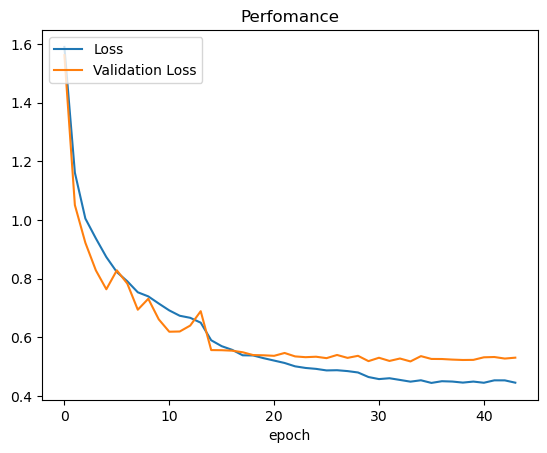

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perfomance')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper left')
plt.show()

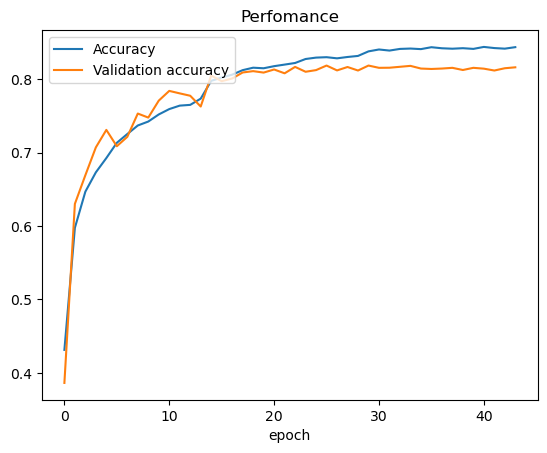

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Perfomance')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

<h3>Evaluation on Test Dataset</h3>

In [13]:
predictions = model.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)
accuracy_score(test_dataset.classes, predictions)

0.814058318072968

<h3>Heatmap & Classification Report</h3>

<Axes: >

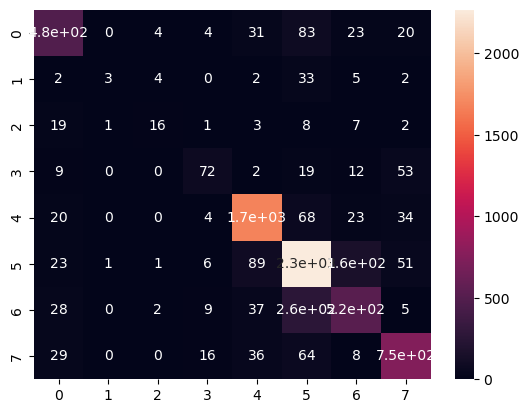

In [14]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [15]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       644
           1       0.60      0.06      0.11        51
           2       0.59      0.28      0.38        57
           3       0.64      0.43      0.52       167
           4       0.89      0.92      0.91      1827
           5       0.81      0.87      0.84      2597
           6       0.69      0.60      0.64       856
           7       0.82      0.83      0.82       900

    accuracy                           0.81      7099
   macro avg       0.73      0.59      0.62      7099
weighted avg       0.81      0.81      0.81      7099



# Saving Model

In [ ]:
model_json = model.to_json()
with open('emotionClass.json', 'w') as json_file:
    json_file.write(model_json)

model_saved = save_model(model, 'emotionWeight.hdf5')

# Test on Webcam (Run this Section to test)

In [2]:
# Load Haarcascade for face detection
face_detector = cv2.CascadeClassifier('Haarcascade/haarcascade_frontalface_default.xml')

In [3]:
# Load Model for Emotion Recognition
with open('Model/emotionClass.json') as json_file:
    json_saved = json_file.read()
json_saved

model_loaded = model_from_json(json_saved)
model_loaded.load_weights('Model/emotionWeight.hdf5')
model_loaded.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1

In [4]:
# Emotion labels
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        roi = gray[y:y + h, x:x + w]
        roi = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)  
        roi = cv2.resize(roi, (48, 48))
        roi = roi / 255.0
        roi = np.expand_dims(roi, axis=0)

        predictions = model_loaded.predict(roi)
        emotion_label = emotions[np.argmax(predictions)]

        cv2.putText(frame, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    cv2.imshow("Emotion Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
        break

cap.release()
cv2.destroyAllWindows()
